In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import re
from tqdm import tqdm
from sklearn.compose import ColumnTransformer

In [17]:
path_file= 'data/trainset.csv'
df = pd.read_csv(path_file)
test_df= pd.read_csv('data/testset.csv')

In [18]:
#Visualisation des données

print(df.head())
df.describe()
print(f"Aperçu du dataset:\n{df.dtypes}")
print(f"Taille du dataset: {df.shape}")


                             product_id category_id  \
0  86caaf89-8156-42f4-9fd8-10e08a325ee1    0a04a732   
1  a723802b-72b1-4f0e-b618-93776190bfc9    1ae3c505   
2  c2bfc33d-b52a-4ba1-b7ee-cdf3b4e52625    1a6f4f23   
3  7ee2b19e-3e74-47e8-a91d-ab6311c3a44c    f5856233   
4  a00557c5-1934-4223-bdee-3c74710aa881    c7049963   

                                       category_path  \
0  e3a03b90/72a77496/cfcafc53/b4ad0c8c/c0887815/c...   
1       e3a03b90/72a77496/cfcafc53/17b1bfd8/1ae3c505   
2       e3a03b90/107f27db/f59b9a2e/2050ad6d/1a6f4f23   
3  e3a03b90/e056c138/ec34940b/6ceb5201/1fd7323c/8...   
4  e3a03b90/79f03259/55eb19f3/ae8739c9/cbced5e2/7...   

                                               title  \
0         Lindy 37771 Cable d'antenne Premium M/M 1m   
1  Camescope Camera Video 4K 30MP Caméscope avec ...   
2  Caso WineComfort 38 Cave à vin design pour max...   
3  CLAIREFONTAINE Lot de 2 Ramettes 125 Feuilles ...   
4       Sac Banane Bumbumbag Sundae Transparent Vert

**Analyse des données**

* On peut écarter les variables _product\_id_, _category\_path_, _color_ car elles n'apportent que peu d'informations pour prédire la catégorie.
* Certaines descriptions sont rédigées dans des langues autres que le français.

brand
Microsoft    618
Sony         403
Samsung      272
Mindscape    262
Canon        245
            ... 
N\W            1
XINJIA         1
Kuvings        1
YPSMJLL        1
LQMILK         1
Name: count, Length: 8286, dtype: int64
category_id
734ca10c    466
da04a809    445
d9f533b4    431
e5ae58c9    391
747b1103    388
           ... 
1ddc63f9     73
999632b0     71
d1a0ee92     70
1778b75f     69
06ff5497     66
Name: count, Length: 100, dtype: int64


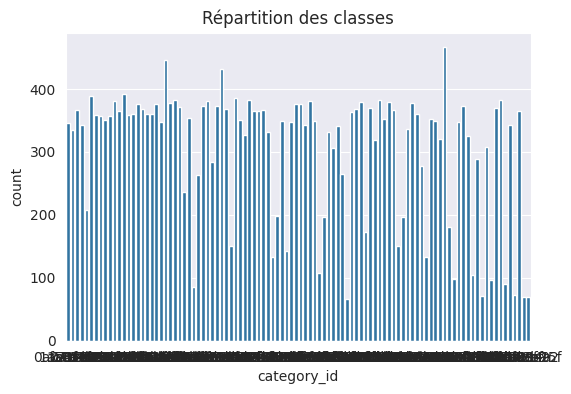

In [20]:
# Aperçu de la proportion des données cibles

print(df["brand"].value_counts())
print(df["category_id"].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=df["category_id"])
plt.title("Répartition des classes")
plt.show()

Dans l'ensemble, nous observons une répartition des catégories assez équilibrée. Toutefois, le catalogue conserve une forte dominante technologique, illustrée par la présence de marques telles que Microsoft ou Sony.

In [21]:
# Exploration des données manquantes

num_NaN_columns=df.isna().sum()
print(num_NaN_columns)

product_id           0
category_id          0
category_path        0
title                0
description       8169
brand              858
color            15800
dtype: int64


Nous observons 27 % de valeurs manquantes pour les descriptions et 2 % pour les marques. Ce taux est significatif, même si la description demeure une variable moins déterminante que le titre ou la marque pour la classification. On va remplacer les données manquantes par des chaines de caractères vides.

Pour le preprocessing, l'objectif est de nettoyer le texte avant la vectorisation TF-IDF. L'utilisation de modèles linguistiques lourds (comme Spacy) a été écartée : le coût en temps de calcul s'est avéré plus élevé pour un gain de performance faible.

Pour la vectorisation, j'ai concaténé les variables description, titre et brand. En terme de feature engineering, le titre et la marque étant plus discriminants, j'ai décidé d'artificiellement les renforcés (répétition du titre ×3 et de la marque ×2). Cette stratégie a permis une augmentation de l'accuracy sur le jeu de validation.

In [22]:
# Preprocessing

tqdm.pandas()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'(\d+)([a-z]+)', r'\1 \2', text) # Séparation entre mot et chiffre Iphone12 -> Iphone 12
    text = re.sub(r'([a-z]+)(\d+)', r'\1 \2', text) # Séparation entre chiffre et mot 3kg -> 3 kg
    text = re.sub(r'[^\w\s]', ' ', text) # Ponctuation
    text = re.sub(r'<[^>]+>', ' ', text) # Balise HTML
    return text


def preprocess_features(df):
    df=df.copy()
    df=df.fillna('')
    # On rajoute de l'importance au colonne title et brand qui apporte plus d'information que description et color
    colonnes_a_joindre=['title','title', 'title','description','brand','brand','color']
    df=df.fillna('')
    df["Text"]= df[colonnes_a_joindre].agg(' '.join, axis=1)
    df["text_clean"]=df["Text"].progress_apply(preprocess_text)
    # Pour éviter les doublons d'espaces
    df["text_clean"] = df["text_clean"].str.replace(r'\s+', ' ', regex=True).str.strip()
    return df


**Choix du modèle** :
Après comparaison de plusieurs algorithmes (MultiNB, Régression Logistique, Random Forest, etc.), le SVM linéaire a été retenu. Il offre le meilleur compromis, étant à la fois le plus rapide et celui affichant les performances les plus élevées.

**Vectorisation TF-IDF** :
Les hyperparamètres ont été optimisés spécifiquement pour notre problématique. J'ai exploré la possibilité de traiter les trois colonnes séparément (via un ColumnTransformer) pour un prétraitement indépendant. Cependant, j'ai finalement privilégié la stratégie de concaténation, cette approche étant plus simple à implémenter tout en restant très efficace en temps de calcul.

In [23]:
# Utilisation de TF-IDF pour le NLP et entrainement du model LinearSVC

df=preprocess_features(df)
X=df.drop(columns='category_id')
y=df["category_id"]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer(
    transformers=[
        # A. Pour le TITRE : On y va fort sur les caractères (Anti-fautes)
        ('text_clean_vec', TfidfVectorizer(
            ngram_range=(1, 2),     # Capture "Sac à dos"
            min_df=2,
            max_df=0.9,
            sublinear_tf=True),
            'text_clean')
    ],
    remainder='drop'
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(class_weight='balanced',random_state=100)),
])

clf.fit(X_train, y_train)

# Cross Validation
print(cross_val_score(clf,X_train, y_train, cv=5, scoring='accuracy').mean())

100%|██████████| 30520/30520 [00:02<00:00, 12142.71it/s]


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  16.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  12.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  12.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  12.3s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   3.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  12.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.2s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  12.4s
0.860583325492193


In [ ]:
# Recherche des meilleurs paramètres

param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__class_weight': ['balanced', None],
    'classifier__loss': ['hinge', 'squared_hinge'],
}

grid = GridSearchCV(
    clf,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print(f"Meilleur score : {grid.best_score_:.4f}")
print("Meilleurs paramètres :")
print(grid.best_params_)

Le GridSearch a démontré que les hyperparamètres par défaut du LinearSVC (notamment C=1.0) offraient les résultats optimaux, rendant inutile une complexification du modèle.

In [26]:
# Résultat sur le testset

test_df=preprocess_features(test_df)
X_test_df=test_df.drop(columns='category_id')
y_test_df=test_df["category_id"]

y_pred = clf.predict(test_df)
print(f"Précision sur le testset : {accuracy_score(y_test_df, y_pred)}")
print(classification_report(y_test_df, y_pred))

# Classement des différenes catégories
report_dict=classification_report(y_test_df, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
lignes_a_exclure = ['accuracy', 'macro avg', 'weighted avg']
df_classes = df_report.drop(lignes_a_exclure, errors='ignore')
df_trie = df_classes.sort_values(by='precision', ascending=False)

print("TOP 10 des Catégories les mieux prédites ")
print(df_trie.head(10))

print("\nFLOP 10 (Les pires précisions) ")
print(df_trie.tail(10))

100%|██████████| 7631/7631 [00:00<00:00, 10959.84it/s]


Précision sur le testset : 0.8630585768575547
              precision    recall  f1-score   support

    0089ad4b       0.82      0.88      0.85        84
    0184ed7a       0.75      0.71      0.73        79
    06ff5497       0.83      0.71      0.77        14
    0726e597       0.79      0.81      0.80       105
    09bacde9       0.77      0.77      0.77        26
    0a04a732       0.83      0.77      0.80       110
    0b3dec20       0.78      0.82      0.80        44
    0c60b2a9       0.96      0.94      0.95        97
    0cd73699       0.96      0.98      0.97        94
    141a04ef       0.81      0.78      0.80       101
    1778b75f       0.90      0.79      0.84        24
    1a6f4f23       0.99      1.00      0.99        87
    1ae3c505       0.87      0.96      0.91        70
    1b99320d       0.86      1.00      0.92        43
    1c5e6a37       0.95      0.90      0.92        87
    1cab2f83       0.83      0.82      0.82        94
    1ddc63f9       0.92      0.52  

Sur le jeu de données final, nous obtenons une accuracy globale de 0.871 et un f1-score macro avg légèrement inférieur ce qui montre même sur les catégories rares le modèle reste performant. Une analyse détaillée par classe triée par précision permet d'identifier les catégories les mieux prédites et celles où le modèle a le plus de difficultés (la catégorie la moins bien classée est celle des jouets pour enfants). Le choix de l'accuracy comme métrique de référence est justifié par le fait que les classes sont relativement équilibrées.

Dans une optique d'amélioration du modèle, nous avons analysé les catégories générant le plus d'erreurs. Il est également pertinent d'étudier l'impact des données manquantes : l'absence de description empêche-t-elle le modèle de classer correctement les produits ?

In [27]:
# Explication potentiels des erreurs de notre modèle

taille=test_df.shape[0]
df_analyse = test_df.copy()
df_analyse['y_true'] = y_test_df
df_analyse['y_pred'] = y_pred

# On crée un masque 'erreur'
mask_erreur = df_analyse['y_true'] != df_analyse['y_pred']
df_erreurs = df_analyse[mask_erreur] # data où le modèle s'est trompé

print(f"Nombre total d'erreurs : {len(df_erreurs)} sur {taille} données")

# Parmi les erreurs, qui n'a pas de description ?
# Transforme NaN en '' et si '' alors True
mask_sans_desc = df_erreurs['description'].fillna('').str.strip() == ''
erreurs_sans_desc = df_erreurs[mask_sans_desc]

print(f"Nombre d'erreurs sans description : {len(erreurs_sans_desc)}")

ratio = len(erreurs_sans_desc) / len(df_erreurs) * 100
print(f"Pourcentage des erreurs dues à une absence de description : {ratio:.2f}%")

# On affiche une colonne, la Vraie classe et la Prédiction
colonnes_a_voir = ['title', 'y_true', 'y_pred']
print("\nExemple de produits mal classés sans description")
print(df_erreurs[colonnes_a_voir])

Nombre total d'erreurs : 1045 sur 7631 données
Nombre d'erreurs sans description : 303
Pourcentage des erreurs dues à une absence de description : 29.00%

Exemple de produits mal classés sans description
                                                  title    y_true    y_pred
9     Xyxiaolun Mini-Four Multi-Fonction De Cuisson ...  c69a0f93  48907735
16    HJWL Console Rétro Console Jeu Vidéo Mini Cons...  c7049963  09bacde9
20    Barre de Son Portable Bluetooth 4.0 Enceintes ...  bc576a15  73d6d79a
29    QPOLLY Housse Miroir Compatible avec Huawei No...  09bacde9  999632b0
33    PROMT Office 7.8 Französisch-Deutsch/Deutsch-F...  3bc90ab4  40e0fb5b
...                                                 ...       ...       ...
7575                       Pierre Haut-Parleur STL 80 W  bc576a15  73d6d79a
7576                       Magix music maker MX control  ade715dc  7cc22399
7607  JVC UX-LP55BE Micro Chaîne CD oblique avec Sta...  6bf135c9  73d6d79a
7620            Fisher Price Power W

On obtient que 30 % des erreurs sont sans description, ce qui peut constituer un axe d'amélioration possible. Il est également pertinent d'évaluer la proportion de descriptions rédigées dans une langue étrangère, afin de déterminer si ce facteur contribue aux erreurs de classification.

In [28]:
# Détection de langue des description

from langdetect import detect, LangDetectException, DetectorFactory

def detecter_langue(texte):
    if pd.isna(texte):
        return "unknown"
    texte = str(texte)
    texte_propre = re.sub(r'[^a-zA-Z]', ' ', texte).strip()

    try:
        langue = detect(texte_propre)
        return langue
    except LangDetectException:
        # Arrive si le texte n'est que du bruit
        return "unknown"
    except Exception:
        return "error"

df_langue=df.copy()
df_langue['langue_detectee'] = df['description'].apply(detecter_langue)

In [29]:
# Aperçu des descriptions de différentes langues anglais et allemand
df_langue['texte_en'] = np.where(df_langue['langue_detectee'] == 'en', df['description'], np.nan)
df_langue['texte_de'] = np.where(df_langue['langue_detectee'] == 'de', df['description'], np.nan)


print(f"{df_langue.texte_en.dropna().head()}\n")
print(df_langue.texte_de.dropna().head())


40     Description du produit      Bar craft luxury s...
79     Spécifications:  Type d'élément: Courroie dent...
146    Microsoft 5 Client Access Licence Pack to add ...
155    Citizen IDP562 Black & Red Compatible Ribbons ...
170     AEG Boombox stéréo pour iPhone / iPod SR 4337 IP
Name: texte_en, dtype: object

2       Für perfekt temperierte Weine sorgt von nun a...
75     CITRIX ACCESS ESSENTIALS - (VERSION 2.0 ) - LI...
99                           Besonderheiten: USK 6 Jahre
147    Description du produit MAGIX Web Designer 11 P...
191    <p>Geben sie ihrem Pro-Ject Plattenspieler sei...
Name: texte_de, dtype: object


La détection de la langue est difficile, surtout quand la description devient très technique avec beaucoup de caractéristiques et de marques.

In [30]:
print("Statistiques des langues dans notre dataset :")
print(df_langue['langue_detectee'].value_counts())

Statistiques des langues dans notre dataset :
langue_detectee
fr         19695
unknown     8218
en          1634
de           411
it           104
ca            81
es            68
pt            64
ro            33
da            30
nl            22
pl            21
id            21
so            20
tl            17
vi            16
no            12
sv             9
sw             9
hr             8
cy             7
af             6
fi             4
et             4
tr             2
sk             1
sl             1
lt             1
hu             1
Name: count, dtype: int64


Dans notre dataset d'entrainement, la majorité des descriptions données sont en français ou bien unknown (les données manquantes), il n'y a qu'une faible partie en anglais et en allemand,  cela veut dire que dans notre modèle, on devrait mieux prédire en théorie les données ou les descriptions sont en français que le reste. On peut essayer de voir la langue des données mal classés

In [31]:
test_df_langue= test_df.copy()
test_df_langue['langue_detectee'] = test_df['description'].apply(detecter_langue)
print("Statistiques des langues dans notre dataset test :")
print(test_df_langue['langue_detectee'].value_counts())

Statistiques des langues dans notre dataset test :
langue_detectee
fr         5012
unknown    2009
en          386
de           96
es           17
ca           17
ro           11
pt           10
it           10
so            8
da            8
pl            6
nl            6
vi            5
tl            5
sv            4
id            3
hr            3
no            3
et            2
hu            2
cy            2
af            2
sq            1
fi            1
lt            1
sw            1
Name: count, dtype: int64


In [32]:
df_erreurs_langue=df_erreurs.copy()
df_erreurs_langue['langue_detectee'] = df_erreurs['description'].apply(detecter_langue)
print("Statistiques des langues dans notre dataset d'erreurs :")
print(df_erreurs_langue['langue_detectee'].value_counts())

Statistiques des langues dans notre dataset d'erreurs :
langue_detectee
fr         638
unknown    307
en          52
de          14
ca           5
da           5
it           4
es           3
ro           3
nl           2
tl           2
so           2
id           1
pt           1
hr           1
sv           1
sw           1
lt           1
pl           1
vi           1
Name: count, dtype: int64


L'analyse montre que le modèle est robuste face à la diversité linguistique. J'ai tenté de travailler seules sur les données francophones et cela n'a pas engendré de gain de performance significatif. Par conséquent, le nettoyage spécifique des langues étrangères ne constitue pas un axe d'amélioration prioritaire.

L'analyse des erreurs nous montre des pistes d'amélioration. L'harmonisation linguistique via une traduction automatique n'est pas rentable, car l'appel à une API externe augmenterait la latence lors du preprocessing.

De même, nous avons privilégié une approche TF-IDF légère plutôt que des modèles de Deep Learning (BERT, GPT). Bien que ces derniers capturent mieux le contexte sémantique, leur coût computationnel est disproportionné par rapport au gain de performance espéré sur ce type de catalogue. Enfin, la qualité intrinsèque de la donnée reste le facteur clé : des descriptions plus riches ou des titres plus explicites amélioreraient les résultats.